In [ ]:
import pickle
import geopandas as gpd
import folium
import random


In [61]:
# Load the geometry data for areas
gdf_shp_areas = gpd.read_file("./data/block_groups_shapefiles_with_population.gpkg", layer="areas")
gdf_shp_areas.area_demand = gdf_shp_areas.area_demand.astype(int)

## Budget vs. Coverage trade-off

In [92]:
[entry["budget"] for entry in results]

[50, 100, 150]

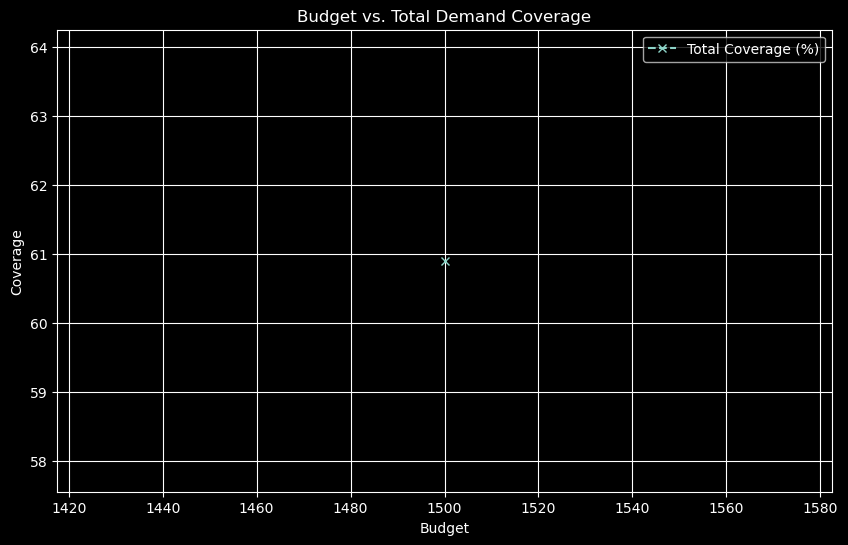

Plot saved as './data/budget_total_coverage_curve.png'.


In [ ]:
import matplotlib.pyplot as plt
import json

# Load results from JSON file
input_file = "./data/model_results_totals.json"
with open(input_file, "r") as f:
    results = json.load(f)

# Extract budgets, absolute coverages, and percentages
budgets = [entry["budget"] for entry in results]
total_coverages = [entry["total_demand_coverage"] for entry in results]
coverage_percentages = [entry["total_coverage_percentage"] for entry in results]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot total coverage percentage
plt.plot(budgets, coverage_percentages, label="Total Coverage (%)", marker="x", linestyle="--")

# Add titles and labels
plt.title("Budget vs. Total Demand Coverage")
plt.xlabel("Budget")
plt.ylabel("Coverage")
plt.legend()

# Add grid for better readability
plt.grid(True)

# Save the plot as an image
output_plot_path = "./data/budget_total_coverage_curve.png"
plt.savefig(output_plot_path)
plt.show()

print(f"Plot saved as '{output_plot_path}'.")

In [98]:
results

[{'budget': 1000,
  'total_demand_coverage': 116346324.77260403,
  'total_coverage_percentage': 33.528927546475124},
 {'budget': 1666,
  'total_demand_coverage': 116346324.7728123,
  'total_coverage_percentage': 33.528927546535144},
 {'budget': 2333,
  'total_demand_coverage': 116346324.7728123,
  'total_coverage_percentage': 33.528927546535144}]

## Charger Placement

### Shapes

In [100]:
# Load the built stations data
with open("./data/model_output/built_stations.pkl", "rb") as f:
    built_stations = pickle.load(f)

# Map the built station data to the GeoDataFrame
gdf_built_stations = gdf_shp_areas.copy()
gdf_built_stations['chargers_built'] = gdf_built_stations['full_id'].map(built_stations).fillna(0)

# Filter out areas with no chargers
gdf_built_stations_nonzero = gdf_built_stations[gdf_built_stations['chargers_built'] > 0]

# Ensure the GeoDataFrame has the correct CRS (WGS84 for compatibility)
if gdf_built_stations_nonzero.crs is None or gdf_built_stations_nonzero.crs.to_string() != "EPSG:4326":
    gdf_built_stations_nonzero = gdf_built_stations_nonzero.to_crs(epsg=4326)

# Style the base layer with gray and transparency
base_style = {
    'fillColor': '#d3d3d3',  # Light gray color for the base map
    'fillOpacity': 0.1,      # Partial transparency
    'color': '#d3d3d3',      # Border color to match the fill
    'weight': 0.5            # Thin border for the areas
}

# Use the GeoPandas `explore` function to visualize with a blue palette
map_stations = gdf_shp_areas.explore(
    style_kwds=base_style,  # Style for the base layer
    tooltip=["full_id"],    # Tooltip for base layer areas
    popup=True              # Enable pop-ups for base layer info
)

# Add the stations layer with the blue palette on top of the base layer
stations_layer = gdf_built_stations_nonzero.explore(
    column="chargers_built",  # The column to visualize
    cmap="Purples",            # Blue color palette
    vmin=-5,                    # Start the color spectrum at 1 (to make it darker for low values)
    vmax=8,
    legend=True,             # Show legend
    legend_kwds={'caption': "Chargers Built"},  # Customize legend caption
    tooltip=["full_id", "chargers_built"],      # Show ID and chargers on hover
    popup=True,              # Enable pop-ups for detailed info
    m=map_stations           # Add to the existing map
)

# Save the map to an HTML file
output_path = "./data/maps/stations_built_map_shapes_upd1.html"
stations_layer.save(output_path)

print(f"Map created and saved as '{output_path}'.")


Map created and saved as './data/maps/stations_built_map_shapes_upd1.html'.


### Points

In [ ]:
# Load the built stations data
with open("./data/model_output/built_stations.pkl", "rb") as f:
    built_stations = pickle.load(f)

# Map the built station data to the GeoDataFrame
gdf_built_stations = gdf_shp_areas.copy()
gdf_built_stations['chargers_built'] = gdf_built_stations['full_id'].map(built_stations).fillna(0)

# Filter out areas with no chargers
gdf_built_stations_nonzero = gdf_built_stations[gdf_built_stations['chargers_built'] > 0]

# Ensure the GeoDataFrame has the correct CRS (WGS84 for compatibility)
if gdf_built_stations.crs is None or gdf_built_stations.crs.to_string() != "EPSG:4326":
    gdf_shp_areas = gdf_shp_areas.to_crs(epsg=4326)
    gdf_built_stations_nonzero = gdf_built_stations_nonzero.to_crs(epsg=4326)

# Calculate centroids for stations
gdf_built_stations_nonzero['centroid'] = gdf_built_stations_nonzero.geometry.centroid

# Create the base map
map_stations = folium.Map(
    location=[gdf_shp_areas.geometry.centroid.y.mean(), gdf_shp_areas.geometry.centroid.x.mean()],
    zoom_start=8
)

# Add transparent base layer for areas with interactivity
folium.GeoJson(
    gdf_shp_areas,
    style_function=lambda x: {
        'fillColor': '#d3d3d3',
        'fillOpacity': 0.4,
        'color': '#d3d3d3',
        'weight': 0.5
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['full_id'],  # Replace with the columns you want to show
        aliases=['Area ID:'],  # Alias for better readability
        localize=True
    ),
    popup=folium.GeoJsonPopup(
        fields=['full_id'],  # Replace with the columns you want to show in the popup
        aliases=['Area ID:'],  # Alias for better readability
        localize=True
    ),
    name='Base Layer'
).add_to(map_stations)

# Add jittered points for chargers
for _, row in gdf_built_stations_nonzero.iterrows():
    chargers = int(row['chargers_built'])  # Number of chargers
    centroid = row['centroid']
    
    # Generate jittered points around the centroid
    for _ in range(chargers):
        jitter_lat = centroid.y + random.uniform(-0.0030, 0.0030)  # Small jitter in latitude
        jitter_lon = centroid.x + random.uniform(-0.0030, 0.0030)  # Small jitter in longitude
        
        # Add the point to the map
        folium.CircleMarker(
            location=[jitter_lat, jitter_lon],
            radius=2,  # Small radius
            color='purple',
            fill=True,
            fill_color='purple',
            fill_opacity=0.8
        ).add_to(map_stations)

# Save the map to an HTML file
output_path = "./data/maps/stations_built_map_points.html"
map_stations.save(output_path)

print(f"Map created and saved as '{output_path}'.")


/var/folders/9q/6xd73j7x5tqg10w1v1xhrcl80000gn/T/ipykernel_18284/3492515622.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_built_stations_nonzero['centroid'] = gdf_built_stations_nonzero.geometry.centroid
/var/folders/9q/6xd73j7x5tqg10w1v1xhrcl80000gn/T/ipykernel_18284/3492515622.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location=[gdf_shp_areas.geometry.centroid.y.mean(), gdf_shp_areas.geometry.centroid.x.mean()],


Map created and saved as './data/maps/stations_built_map_points.html'.


## Area Coverage

### Percentages

In [79]:
# Load the coverage percentages data
with open("./data/model_output/coverage_percentages.pkl", "rb") as f:
    coverage_percentages = pickle.load(f)

# Map the coverage data to the GeoDataFrame
gdf_coverage = gdf_shp_areas.copy()
gdf_coverage['coverage_percentage'] = gdf_coverage['full_id'].map(coverage_percentages).fillna(0)

# Ensure the GeoDataFrame has the correct CRS (WGS84 for compatibility)
if gdf_coverage.crs is None or gdf_coverage.crs.to_string() != "EPSG:4326":
    gdf_coverage = gdf_coverage.to_crs(epsg=4326)

# Style the base layer with gray and transparency
base_style = {
    'fillColor': '#d3d3d3',  # Light gray color for the base map
    'fillOpacity': 0.1,      # Partial transparency
    'color': '#d3d3d3',      # Border color to match the fill
    'weight': 0.5            # Thin border for the areas
}

# Use the GeoPandas `explore` function to visualize the base layer
map_coverage = gdf_shp_areas.explore(
    style_kwds=base_style,  # Style for the base layer
    tooltip=["full_id", "area_demand"],    # Tooltip for base layer areas
    popup=True              # Enable pop-ups for base layer info
)

gdf_coverage.coverage_percentage= gdf_coverage.coverage_percentage.astype(int)
# Add the area coverage layer with a green palette on top of the base layer
coverage_layer = gdf_coverage.explore(
    column="coverage_percentage",  # The column to visualize
    cmap="YlGn",                   # Yellow-Green color palette for coverage
    vmin=0,                        # Start at 0% coverage
    vmax=100,                      # Max coverage at 100%
    legend=True,                   # Show legend
    tooltip=["full_id", "coverage_percentage", "area_demand"],          # Show on hover
    popup=True,                   # Enable pop-ups for detailed info
    m=map_coverage                # Add to the existing map
)

# Save the map to an HTML file
output_path = "./data/maps/area_coverage_map_percentages_upd1.html"
coverage_layer.save(output_path)

print(f"Map created and saved as '{output_path}'.")


Map created and saved as './data/maps/area_coverage_map_percentages_upd1.html'.


### Absolutes

In [99]:
# Load the coverage percentages data
with open("./data/model_output/coverage_percentages.pkl", "rb") as f:
    coverage_percentages = pickle.load(f)

# Map the coverage data to the GeoDataFrame
gdf_coverage = gdf_shp_areas.copy()
gdf_coverage['coverage_percentage'] = gdf_coverage['full_id'].map(coverage_percentages).fillna(0)
gdf_coverage['coverage_absolute'] = ((gdf_coverage['coverage_percentage']/100) * gdf_coverage['area_demand']).astype(int)

# Ensure the GeoDataFrame has the correct CRS (WGS84 for compatibility)
if gdf_coverage.crs is None or gdf_coverage.crs.to_string() != "EPSG:4326":
    gdf_coverage = gdf_coverage.to_crs(epsg=4326)

# Style the base layer with gray and transparency
base_style = {
    'fillColor': '#d3d3d3',  # Light gray color for the base map
    'fillOpacity': 0.1,      # Partial transparency
    'color': '#d3d3d3',      # Border color to match the fill
    'weight': 0.5            # Thin border for the areas
}

# Use the GeoPandas `explore` function to visualize the base layer
map_coverage = gdf_shp_areas.explore(
    style_kwds=base_style,  # Style for the base layer
    tooltip=["full_id", "area_demand"],    # Tooltip for base layer areas
    popup=True              # Enable pop-ups for base layer info
)

gdf_coverage.coverage_percentage= gdf_coverage.coverage_percentage.astype(int)
vmax_value = gdf_coverage.coverage_absolute.quantile(0.8)
# Add the area coverage layer with a green palette on top of the base layer
coverage_layer = gdf_coverage.explore(
    column="coverage_absolute",  # The column to visualize
    cmap="YlGn",                   # Yellow-Green color palette for coverage
    vmin=0,                        
    vmax=vmax_value,               
    legend=True,                   # Show legend
    tooltip=["full_id", "coverage_absolute", "coverage_percentage", "area_demand"],          # Show on hover
    popup=True,                   # Enable pop-ups for detailed info
    m=map_coverage                # Add to the existing map
)

# Save the map to an HTML file
output_path = "./data/maps/area_coverage_map_absolutes_upd1.html"
coverage_layer.save(output_path)

print(f"Map created and saved as '{output_path}'.")


Map created and saved as './data/maps/area_coverage_map_absolutes_upd1.html'.
